# Localization 1

This is my implementation of the Localization part 1 lectures from Lazy Programmer's Deep Learning and Advanced Computer Vision course. The objective is to start by creating black and white images where there is a black background and a single randomly placed, random sized white rectangle. We then train a network to output the location of the rectangle.

Using a topless, pre-trained VGG16 network as a feature extractor we build a small dense layer with four outputs. The outputs represent the column, row, width and height of the white rectangle.

As directed by the tutorial, I apply the sigmoid activation function to all four of the outputs.

Code for this article can be found at [https://github.com/jpmasters/jupyter-notebooks/blob/main/localization-1.ipynb](https://github.com/jpmasters/jupyter-notebooks/blob/main/localization-1.ipynb)

In [46]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import random
from PIL import Image, ImageDraw

Create the model by starting with a trained, topless VGG16, flattening the outputs as they'll be 2D tensors, and the final dense layer with four outputs and sigmoid activation.

VGG16 inputs are usually images of shape 224x224 pixels but to make things a bit faster, we're going to use images of 100x100 pixels.

In [47]:
IMAGE_DIM = 100

We want to make sure we don't try and train the Conv2D layers as it'll take too long so that part of the model is marked as untrainable.

It's then compiled with binary crossentropy as the loss function and the Adam optimizer.

In [48]:
# create the model
vgg16 = tf.keras.applications.vgg16.VGG16(
    input_shape=(IMAGE_DIM, IMAGE_DIM, 3), 
    include_top=False, 
    weights='imagenet'
)

# we don't want to train the VGG16 model
vgg16.trainable = False

# create the dense layer
x = tf.keras.layers.Flatten()(vgg16.output)
x = tf.keras.layers.Dense(4, activation="sigmoid")(x)

# and build and compile it
model = tf.keras.Model(vgg16.input, x, name="Localization_Model")
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "Localization_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128)

You can see from the summary above that nearly all of the weights are untrainable but the final flatten and dense layer weights are.

Next we create a generator for the training images. It works by creating them at random on the fly. For this I created class derived from [tf.keras.utils.Sequence](https://www.tensorflow.org/api_docs/python/tf/keras/utils/Sequence).

Note that while the sigmoid function is good with values of x from -5 to 5 (and probably beyond). In this case we'll use the range 0..1.

In [49]:
class LocalizationSequence(tf.keras.utils.Sequence):
    def __init__(self, batch_size):
        self.batch_size = batch_size
        
    def preprocess_y_value(self, y):
        """
        Sets the range of y to 0..1.
        """
        return y / IMAGE_DIM
        
        
    def generate_image(self):
        """
        Generates a random image with a black background and a single white
        rectangle inside it. 
        """
        img = np.zeros((IMAGE_DIM, IMAGE_DIM, 3))
        block_top = random.randint(1, IMAGE_DIM - 2)
        block_left = random.randint(1, IMAGE_DIM - 2)
        block_width = random.randint(1, IMAGE_DIM - 1 - block_left)
        block_height = random.randint(1, IMAGE_DIM - 1 - block_top)
        
        for row in range(block_top, block_top + block_height):
            for col in range(block_left, block_left + block_width):
                img[row][col] = [1., 1., 1.]
        
        return img, self.preprocess_y_value(
            np.array([block_top, block_left, block_height, block_width])
        )
        
        
    def __len__(self):
        """
        We generate the images on the fly so just return the batch size.
        """
        return self.batch_size
    
    
    def __getitem__(self, idx):
        """
        Return a batch of images preprepared for training. I.e. colour ranges
        are 0..1 and not 0..255.
        """
        batch_x = np.empty(
            [self.batch_size, IMAGE_DIM, IMAGE_DIM, 3], 
            dtype=np.float32
        )
        
        batch_y = np.empty([self.batch_size, 4], dtype=np.float32)
        
        for i in range(self.batch_size):
            batch_x[i], batch_y[i] = self.generate_image()
            
        return batch_x, batch_y
            

Test out the LocalizationSequence by creating a batch of images. It doesn't matter what value is passed as the index parameter of `LocalizationSequence.__getitem__(idx)` as it'll generate a random batch every time.

In [50]:
seq = LocalizationSequence(batch_size=32)
batch_x, batch_y = seq.__getitem__(0)

Now we can draw them out and see what we generated.

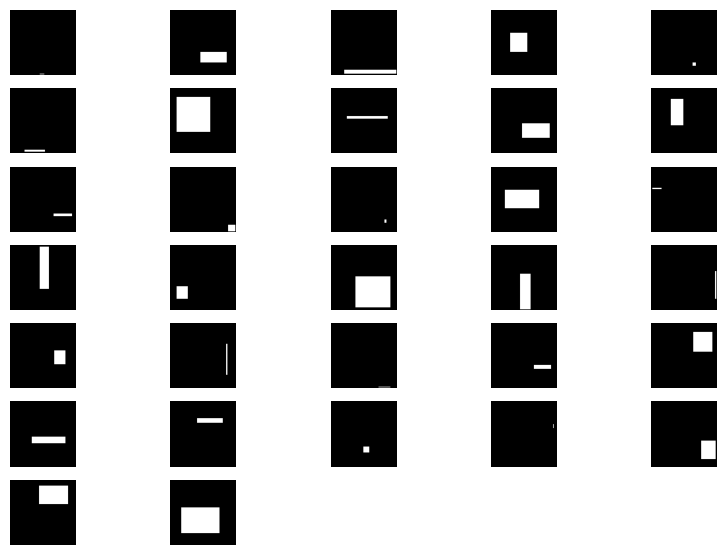

In [51]:
plt.rcParams["figure.figsize"] = (10, 10)
for i in range(min(50, seq.__len__())):
    ax = plt.subplot(10, 5, i + 1)
    ax.set_axis_off()
    ax.imshow(batch_x[i])
    
plt.show()

Next we train the model using the LocalizationSequence object.

In [52]:
history = model.fit(seq, epochs=8)

Epoch 1/8
32/32 [==============================] - 35s 1s/step - loss: 0.5730 - accuracy: 0.6699
Epoch 2/8
32/32 [==============================] - 36s 1s/step - loss: 0.5057 - accuracy: 0.8906
Epoch 3/8
32/32 [==============================] - 37s 1s/step - loss: 0.4984 - accuracy: 0.9082
Epoch 4/8
32/32 [==============================] - 37s 1s/step - loss: 0.4916 - accuracy: 0.9160
Epoch 5/8
32/32 [==============================] - 37s 1s/step - loss: 0.4889 - accuracy: 0.9414
Epoch 6/8
32/32 [==============================] - 39s 1s/step - loss: 0.4881 - accuracy: 0.9209
Epoch 7/8
32/32 [==============================] - 41s 1s/step - loss: 0.4873 - accuracy: 0.9297
Epoch 8/8
32/32 [==============================] - 42s 1s/step - loss: 0.4876 - accuracy: 0.9473


Plot the accuracy from the `model.fit()`.

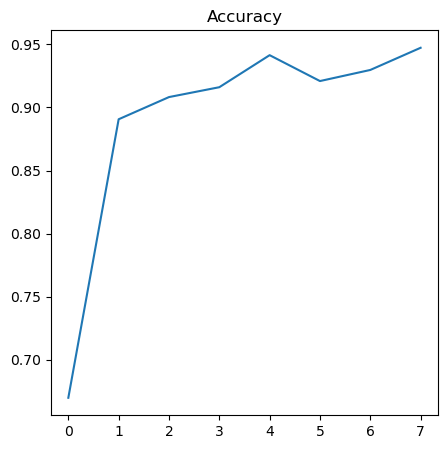

In [53]:
plt.rcParams["figure.figsize"] = (5, 5)
plt.plot(history.history['accuracy'])
plt.title('Accuracy')
plt.show()

Training can take some time so save out the model so it can be loaded from disk in future.

In [54]:
model.save('saved-models/localization-1.h5', overwrite=True)

The `to_pil_rect()` function takes the y outputs from the model and converts the values into the correct coordinates for the input.

In [55]:
def to_pil_rect(y):
    rv = y * IMAGE_DIM
    rv = np.clip(rv, 1, IMAGE_DIM)
    [top, left, height, width] = rv
    height += top
    width += left
    rv[2] = height
    rv[3] = width
    return rv

The sequence object can be used to create a set of images we can use for prediction.

In [63]:
x, y = seq.__getitem__(0)
print(f'Generated data for predictions: {x.shape}')

Generated data for predictions: (32, 100, 100, 3)


As you can see, we've created a batch of 32 test images.

In [64]:
x.shape

(32, 100, 100, 3)

Use the trained model to make some predictions from the new batch.

In [65]:
y_predicted = model.predict(x)

1/1 [==============================] - 1s 1s/step


Create the boxes for both the actual boxes and the predicted ones.

In [66]:
predicted_boxes = np.zeros((seq.batch_size, 4))
actual_boxes = np.zeros((seq.batch_size, 4))

for i, pred in enumerate(y_predicted):
    predicted_boxes[i] = to_pil_rect(pred)
    actual_boxes[i] = to_pil_rect(y[i])

Convert the numpy array into a PIL image so we can work with it as an image.

In [67]:
def add_bounding_boxes():
    rv = np.zeros((seq.batch_size, IMAGE_DIM, IMAGE_DIM, 3), dtype=np.uint8)
    for i in range(seq.batch_size):
        im = Image.fromarray(np.uint8(x[i] * 255), mode='RGB')

        draw = ImageDraw.Draw(im)

        draw.rectangle(
            [actual_boxes[i][1], 
             actual_boxes[i][0], 
             actual_boxes[i][3], 
             actual_boxes[i][2]], outline='yellow')

        draw.rectangle(
            [predicted_boxes[i][1], 
             predicted_boxes[i][0], 
             predicted_boxes[i][3], 
             predicted_boxes[i][2]], outline='green')
        
        rv[i] = np.array(im).astype(dtype=np.uint8)

    return rv

In [68]:
final_images = add_bounding_boxes()

Now we can draw some of the images that were used to create the predictions and overlay the localization rectangles on top of them. You can see that the accuracy isn't brilliant but it's not too bad considering it's a very simple dense network and the feature extraction part of the VGG model probably isn't designed for images this simple. In future experiments, this will change to something more interesting.

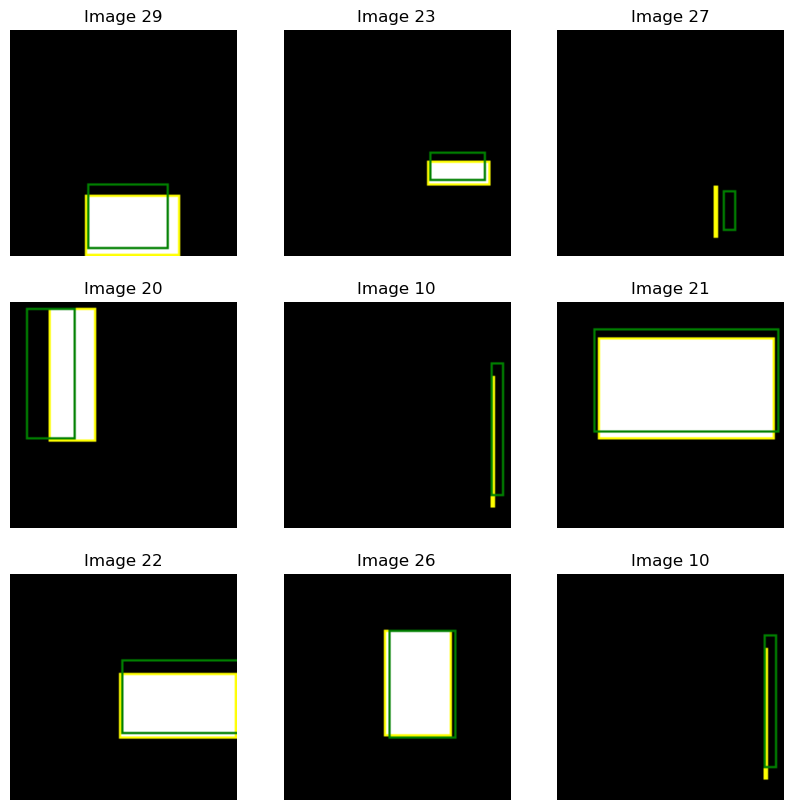

In [69]:
plt.rcParams["figure.figsize"] = (10,10)
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    im_idx = random.randint(0, seq.batch_size - 1)
    ax.imshow(final_images[im_idx])
    ax.set_axis_off()
    ax.set_title(f'Image {im_idx}')

In the output above you can see the green boxes that are the results of the predictions and the yellow boxes that use the same maths to reverse the sigmoid function and validate that that maths is correct.